# Time Series Clustering

In [2]:
import os
import io
import zipfile 
import requests

import numpy as np
import pandas as pd
import geopandas as gpd
#import choroplethNYC as cp

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 6

np.random.seed(111222)

In [3]:
# Parameters / helpers
date_range = list(range(1994, 2015))
data_dir = os.getenv('PUIDATA', './')

# Helpers for census data access
get_fname = lambda url: os.path.join(data_dir, 'census', os.path.splitext(os.path.basename(url))[0] + '.txt')
get_url = lambda y: 'https://www2.census.gov/programs-surveys/cbp/datasets/{}/zbp{:02d}totals.zip'.format(y, y%100)

# zipcode shapefile data locations
shp_url = 'https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip'
shp_fname = os.path.join(data_dir, 'nyc-zip-shp')

## TASKS:
1. load data
2. cluster # establishments, silhouette score
3. plot cluster centers
4. repeat for another clustering algorithm
5. map clusters
6. compare algorithms
7. interpretation

## Task 1: Load data
The Zip Code Shapefile is retrieved from the [NYC Open Data website](https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip). 
The Census County Business Patterns (CBP) for a given year can be found at this url pattern:
https://www2.census.gov/programs-surveys/cbp/datasets/{%Y}/zbp{%y}totals.zip

e.g. for 2004:
https://www2.census.gov/programs-surveys/cbp/datasets/2004/zbp04totals.zip

### Processing data
* Only the zipcode, number of establishments, and the year were used.
* Only zipcodes with all 21 timesteps and that were found in the shapefile were used (243 zips)
* Each zip code was standardized individually by subtracting the mean and dividing by the standard deviation.

In [4]:
## Load Zip Code Shapefile.
# download if it doesn't exist
if not os.path.exists(shp_fname):
    print('downloading', shp_url)
    zipfile.ZipFile(io.BytesIO( requests.get(shp_url).content )).extractall(shp_fname)

# Read in shapefile
gdf_full = gpd.read_file(shp_fname)
gdf_full.ZIPCODE = gdf_full.ZIPCODE.astype(int)
print(gdf_full.shape)
gdf_full.head()

('downloading', 'https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip')


BadZipfile: File is not a zip file

In [5]:
## Load Census Data.
# Download census data if it doesn't exist
for y in date_range:
    url = get_url(y)
    fname = get_fname(url)
    if not os.path.exists(fname):
        print('downloading {}'.format(url))
        zipfile.ZipFile(io.BytesIO( requests.get(url).content )).extractall(os.path.dirname(fname))

# load all csvs
df = pd.concat([
    pd.read_csv(get_fname(get_url(y))).rename(columns=lambda s: s.lower()).assign(year=str(y))
    for y in date_range
])[['zip', 'est', 'year']]

print(df.shape)
df.head()

downloading https://www2.census.gov/programs-surveys/cbp/datasets/1994/zbp94totals.zip
downloading https://www2.census.gov/programs-surveys/cbp/datasets/1995/zbp95totals.zip
downloading https://www2.census.gov/programs-surveys/cbp/datasets/1996/zbp96totals.zip
downloading https://www2.census.gov/programs-surveys/cbp/datasets/1997/zbp97totals.zip
downloading https://www2.census.gov/programs-surveys/cbp/datasets/1998/zbp98totals.zip
downloading https://www2.census.gov/programs-surveys/cbp/datasets/1999/zbp99totals.zip
downloading https://www2.census.gov/programs-surveys/cbp/datasets/2000/zbp00totals.zip
downloading https://www2.census.gov/programs-surveys/cbp/datasets/2001/zbp01totals.zip
downloading https://www2.census.gov/programs-surveys/cbp/datasets/2002/zbp02totals.zip
downloading https://www2.census.gov/programs-surveys/cbp/datasets/2003/zbp03totals.zip
downloading https://www2.census.gov/programs-surveys/cbp/datasets/2004/zbp04totals.zip
downloading https://www2.census.gov/program

,zip,est,year
0,1001,439,1994
1,1002,450,1994
2,1003,10,1994
3,1004,47,1994
4,1005,92,1994


In [6]:
# Get only zips with all 21 timesteps
df1 = df.groupby('zip').count()['est']
full_zips = df1[df1 == 21].index

# Group timesteps by zip
df1 = df.set_index('zip').loc[full_zips].groupby('zip').apply(lambda a: a.est.values)

# Inner merge with shapefile to drop unneeded zipcodes from gdf
gdf = pd.merge(gdf_full, df1.reset_index(), left_on='ZIPCODE', right_on='zip', how='inner')
X = np.array(list(gdf[0].values))
zip_codes = np.array(gdf.zip)
X.shape, zip_codes.shape

KeyError: 'zip'

In [7]:
# Standardize
X = np.apply_along_axis(lambda x: (x - np.mean(x)) / np.std(x), 1, X)
X.mean(1).mean(), X.std(1).mean()

NameError: name 'X' is not defined

## Task 2: Cluster `Number of Establishments`
Clustering is performed using KMeans. The optimal number of clusters is explored by examining the silhouette score for a range of cluster sizes. 

In [8]:
# Calc silhouette scores for a range of cluster sizes
x_clusters = np.arange(2, 11)
sil_scores = [
    silhouette_score(X, KMeans(n).fit(X).labels_)
    for n in x_clusters
]

# Select the cluster size with the highest silhouette score
best_cluster_size = x_clusters[np.argmax(sil_scores)]
print('The best silhouette score is at: {} clusters'.format(best_cluster_size))

# Visualize silhouette scores
plt.figure(figsize=(15,6))
plt.plot(x_clusters, sil_scores)
plt.plot((best_cluster_size, best_cluster_size), (np.min(sil_scores) / 1.1, np.max(sil_scores) * 1.1))
plt.title('KMeans Evaluation: Silhouette Score')
plt.xlabel('N Clusters')
plt.ylabel('Silhouette Score');

NameError: name 'X' is not defined

### Figure 1: Silhouette scores for KMeans. The optimal number of clusters as told by the silhouette method is 2, but looking at 2 clusters is not very interesting so 6 clusters was chosen.

## Task 3: Plot clusters
Each cluster is plotted with all samples in the cluster along with the cluster mean.

In [9]:
# Don't just want 2 clusters sooo
best_cluster_size = 6

In [10]:
def plot_clusters(X, labels, ncols=2, title='Number of Establishments'):
    cluster_size = np.max(labels) + 1 # adjust zero-based
    print(pd.DataFrame(labels, columns=['cluster proportion']).groupby('cluster proportion').size() / X.shape[0])
    
    plt.figure(figsize=(15, 10))
    for i in range(cluster_size):
        plt.subplot(np.ceil(cluster_size / float(ncols)), ncols, i+1)
        plt.plot(date_range, X[labels == i,:].T, linewidth=3, alpha=0.4, c='k')
        plt.plot(date_range, X[labels == i,:].mean(axis=0), linewidth=3)
        
        plt.title('{}: Cluster {} ({} samples)'.format(title, i, (labels == i).sum()))
        plt.xlabel('year')
        plt.ylabel(title)
        plt.xlim([min(date_range), max(date_range)])
        plt.yticks([])
    plt.tight_layout()

In [11]:
# Fit the optimal cluster size to the data
clustering = KMeans(best_cluster_size).fit(X)
kmlabels = clustering.predict(X)
gdf['kmcluster'] = kmlabels

plot_clusters(X, kmlabels)

NameError: name 'X' is not defined

### Figure 2: Cluster assignments for KMeans. Most samples are grouped into one cluster that has 5-10x the number of samples than any other cluster. The second largest cluster also has an increasing trend. While the largest cluster increases more in the last 10 years compared to the first 10 years, the second largest cluster is the inverse.

## Task 4: Clustering using Agglomerative Clustering
The clustering is performed in the same fashion as KMeans, above. A dendrogram is created to visualize the hierarchy of linkages created by this clustering algorithm.

In [12]:
# Fit the optimal cluster size to the data
clustering = AgglomerativeClustering(best_cluster_size)
aglabels = clustering.fit_predict(X)
gdf['agcluster'] = aglabels

plot_clusters(X, aglabels)

NameError: name 'X' is not defined

### Figure 3: The cluster assignments for Agglomerative clustering. The cluster assignments look similar to KMeans, except the difference between the largest cluster and the rest is even more pronounced. All smaller clusters have approximately the same number of samples. The generalized shape of each cluster each have a similar looking cluster in KMeans. 

NameError: name 'X' is not defined

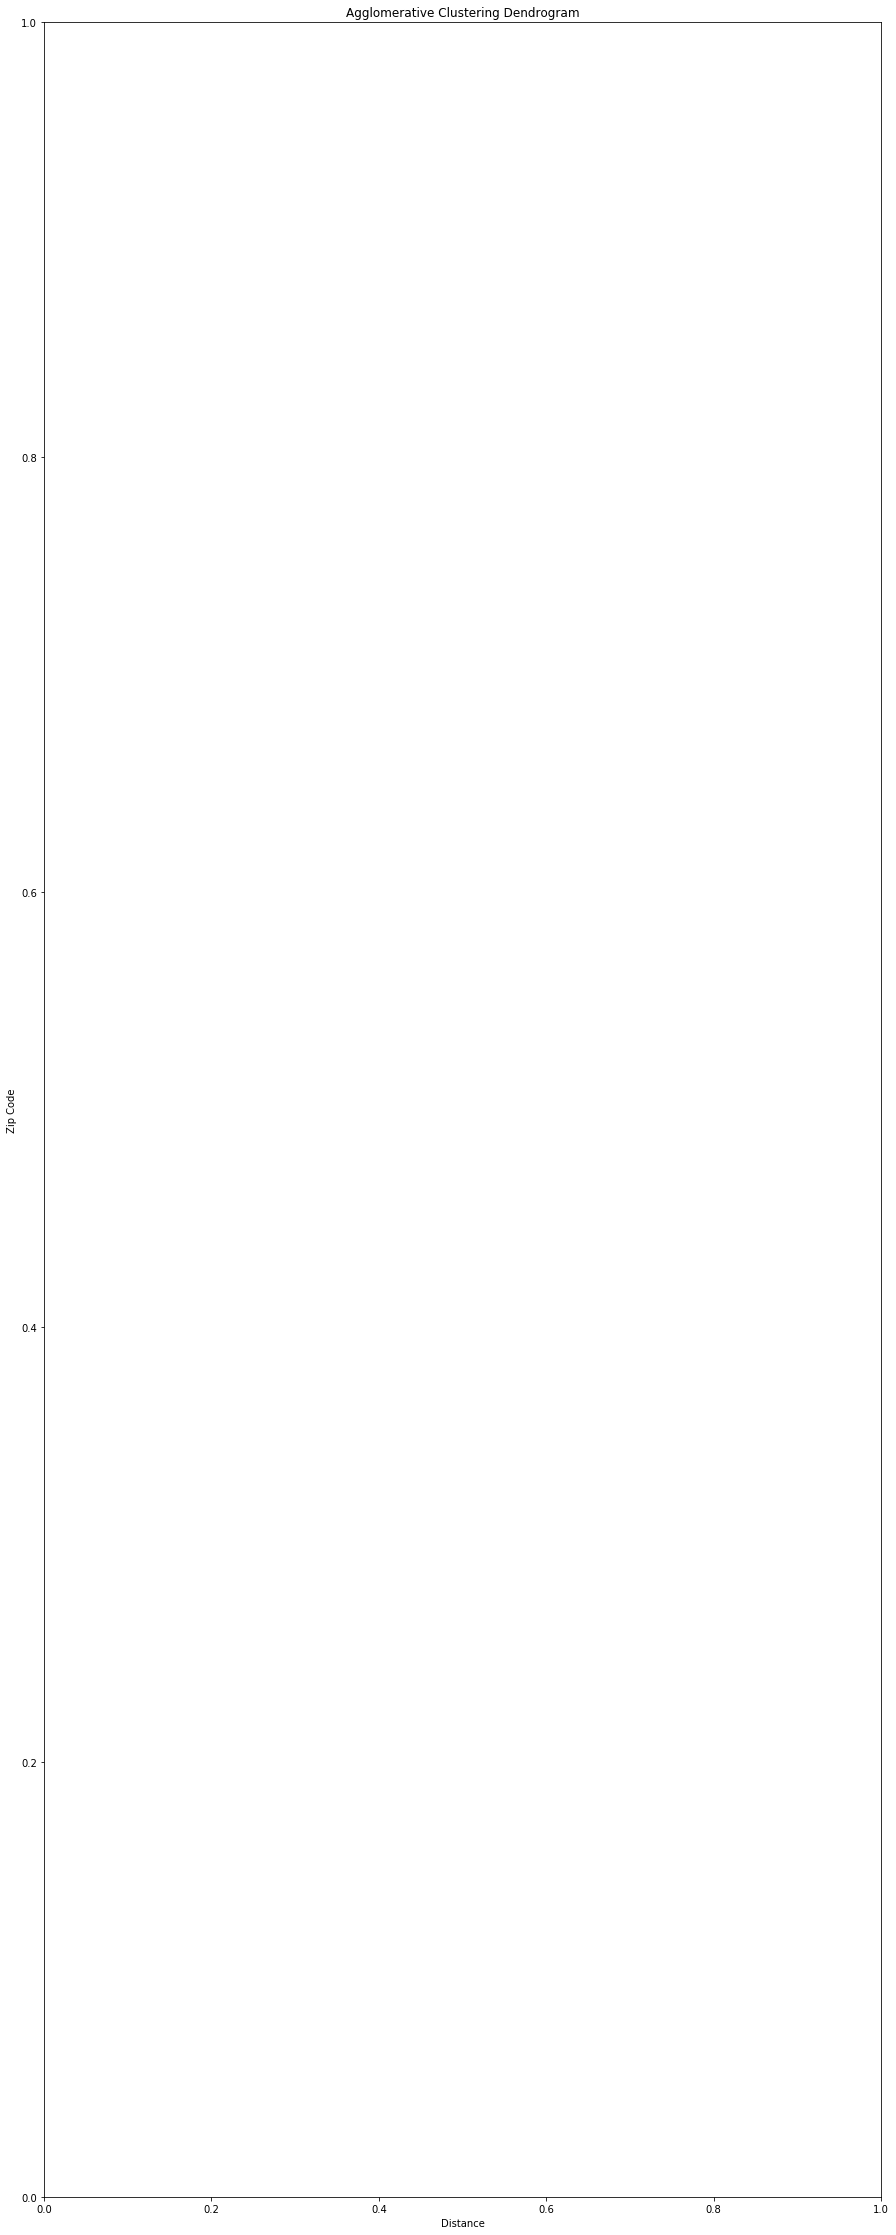

In [13]:
plt.figure(figsize=(15, 40))
plt.title('Agglomerative Clustering Dendrogram')
plt.xlabel('Distance')
plt.ylabel('Zip Code')
dendrogram(
    linkage(X, 'ward'),
    leaf_font_size=10.,
    labels=zip_codes,
    orientation='right',
    color_threshold=15
);

### Figure 4: The Agglomerative Clustering Dendrogram. The dendrogram mirrors the results of the cluster plots, showing one group with a large majority of the samples and the rest having a smaller count. 

## Task 5: Map clusters
The clusters for both KMeans and Agglomerative clustering are shown below.

In [14]:
f, ax, cb = cp.choroplethNYC(gdf, 'kmcluster', kind='discrete', cmap='Dark2')
ax.set_title('KMeans Clustering');

NameError: name 'cp' is not defined

### Figure 5: The KMeans cluster assignments by zip code based on the number of establishments between 1994 and 2014. Most samples belong to clusters # and # which are both increasing.

In [15]:
f, ax, cb = cp.choroplethNYC(gdf, 'agcluster', kind='discrete', cmap='Dark2')
ax.set_title('Agglomerative Clustering');

NameError: name 'cp' is not defined

### Figure 6: The Agglomerative clustering assignments. Most zip codes are assigned to a single cluster. 

## Task 6: Compare the two algorithms

The same basic cluster shapes are shared by both KMeans and Agglomerative Clustering (AC), as stated above. The differences are less in the actual cluster shapes, and are more in what samples get assigned to which cluster.

In [16]:
tsne = TSNE(2)
U = tsne.fit_transform(X)

NameError: name 'X' is not defined

In [17]:
plt.scatter(U[:,0], U[:,1], c=kmlabels)
plt.title('TSNE Embedding of Zip Codes: KMeans Clusters');

NameError: name 'U' is not defined

In [18]:
plt.scatter(U[:,0], U[:,1], c=aglabels)
plt.title('TSNE Embedding of Zip Codes AC Clusters');

NameError: name 'U' is not defined

### Figure 7: Clusterings Visualized in 2D space for a) KMeans clustering, b) Agglomerative Clustering. 
Even in the embedded space, it can be seen that the general cluster assignments are similar between each clustering algorithm. In AC the largest cluster can be seen spreading into the orange (dark blue for KMeans) cluster on the bottom right (cluster colors/orientation may change when you re-run, sorry! That's the trouble with non-determinant algorithms like KMeans and TSNE). Judging in 2D space, it is difficult to determine if there is a natural way to split the largest cluster, though the way KMeans splits it seems more natural than AC because it splits at a place with lower point density.

## Task 7: Interpretation of the clusterings

From both clustering algorithms, it can be said that the vast majority of zip codes have some increasing trend in the overall number of establishments, though the significance of this trend is unknown at this point. Two clusters show little change between the beginning and end of the time series, but one shows a peak and one shows a trough at the center of the time series. One shows an increase in the first 10 years, then a stagnation through the rest of the time series. One cluster shows a visually significant point of change (a drop) around 2001. These locations are primarily in downtown and midtown Manhattan, implying that their drop could have been a result of 911, though that is only a guess.

Points 8 - data not reproducible